## Far-Field Profile of a Cavity

For this demonstration, we will compute the far-field spectra of a resonant cavity mode in a holey waveguide; a structure we had explored in [Tutorial/Resonant Modes and Transmission in a Waveguide Cavity](https://meep.readthedocs.io/en/latest/Python_Tutorials/Resonant_Modes_and_Transmission_in_a_Waveguide_Cavity/). The structure is shown in the left image below.

![center](https://meep.readthedocs.io/en/latest/images/N2ff_comp_cell.png)

To set this up, we simply remove the last portion of [examples/holey-wvg-cavity.py](https://github.com/NanoComp/meep/blob/master/python/examples/holey-wvg-cavity.py), beginning right after the line:

```py
sim.symmetries.append(mp.Mirror(mp.Y, phase=-1))
sim.symmetries.append(mp.Mirror(mp.X, phase=-1))
```

and insert the following lines:

```py
d1 = 0.2

sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=[sources],
                    symmetries=symmetries,
                    boundary_layers=[pml_layers],
                    resolution=resolution)

nearfield = sim.add_near2far(
    fcen, 0, 1,
    mp.Near2FarRegion(mp.Vector3(0, 0.5 * w + d1), size=mp.Vector3(2 * dpml - sx)),
    mp.Near2FarRegion(mp.Vector3(-0.5 * sx + dpml, 0.5 * w + 0.5 * d1), size=mp.Vector3(0, d1), weight=-1.0),
    mp.Near2FarRegion(mp.Vector3(0.5 * sx - dpml, 0.5 * w + 0.5 * d1), size=mp.Vector3(0, d1))
)
```

We are creating a "near" bounding surface, consisting of three separate regions surrounding the cavity, that captures *all* outgoing waves in the top-half of the cell. Note that the *x*-normal surface on the left has a `weight` of -1 corresponding to the direction of the *outward normal* vector relative to the *x* direction so that the far-field spectra is correctly computed from the outgoing fields, similar to other DFT-field derived quantities such as flux and force. The parameter `d1` is the distance between the edge of the waveguide and the bounding surface, as shown in the schematic above, and we will demonstrate that changing this parameter does not change the far-field spectra which we compute at a single frequency corresponding to the cavity mode.

We then time step the fields until they have sufficiently decayed away as the cell is surrounded by PMLs, and output the far-field spectra over a rectangular area that lies *outside* of the cell:

```py
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(0.12, -0.37), 1e-8))

d2 = 20
h = 4

sim.output_farfields(nearfield, "spectra-{}-{}-{}".format(d1, d2, h), resolution,
                     mp.Volume(mp.Vector3(0, (0.5 * w) + d2 + (0.5 * h)), size=mp.Vector3(sx - 2 * dpml, h)))
```

The first item to note is that the far-field region is located *outside* of the cell, although in principle it can be located anywhere. The second is that the far-field spectra can be interpolated onto a spatial grid that has any given resolution but in this example we used the same resolution as the simulation. Note that the simulation itself used purely real fields but the output, given its analytical nature, contains complex fields. Finally, given that the far-field spectra is derived from the Fourier-transformed fields which includes an arbitrary constant factor, we should expect an overall scale and phase difference in the results obtained using the near-to-far-field feature with those from a corresponding simulation involving the full computational volume. The key point is that the results will be qualitatively but not quantitatively identical. The data will be written out to an HDF5 file having a filename prefix with the values of the three main parameters. This includes the far-field spectra for all six field components, including real and imaginary parts.

We run the above modified control file and in post-processing create an image of the real and imaginary parts of H$_z$ over the far-field region which is shown in insets (a) above. For comparison, we compute the steady-state fields using a larger cell that contains within it the far-field region. This involves a continuous source and complex fields. Results are shown in inset (b) of the figure above. The difference in the relative phases among any two points within each of the two field spectra is zero, which can be confirmed numerically. Also, as would be expected, it can be shown that increasing `d1` does not change the far-field spectra as long as the results are sufficiently converged. This indicates that discretization effects are irrelevant.

In general, it is tricky to interpret the overall scale and phase of the far fields, because it is related to the scaling of the Fourier transforms of the near fields. It is simplest to use the `near2far` feature in situations where the overall scaling is irrelevant, e.g. when you are computing a ratio of fields in two simulations, or a fraction of the far field in some region, etcetera.

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 20  # pixels/μm

eps = 13  # dielectric constant of waveguide
w = 1.2  # width of waveguide
r = 0.36  # radius of holes
d = 1.4  # defect spacing (ordinary spacing = 1)
N = 3  # number of holes on either side of defect

sy = 6  # size of cell in y direction (perpendicular to wvg.)
pad = 2  # padding between last hole and PML edge
dpml = 1  # PML thickness
sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction

cell = mp.Vector3(sx, sy, 0)
pml_layers = mp.PML(dpml)

geometry = [
    mp.Block(
        center=mp.Vector3(),
        size=mp.Vector3(mp.inf, w, mp.inf),
        material=mp.Medium(epsilon=eps),
    )
]

for i in range(N):
    geometry.append(mp.Cylinder(r, center=mp.Vector3(0.5 * d + i)))
    geometry.append(mp.Cylinder(r, center=mp.Vector3(-0.5 * d - i)))

fcen = 0.25  # pulse center frequency
df = 0.2  # pulse width (in frequency)

sources = mp.Source(
    src=mp.GaussianSource(fcen, fwidth=df), component=mp.Hz, center=mp.Vector3()
)

symmetries = [mp.Mirror(mp.X, phase=-1), mp.Mirror(mp.Y, phase=-1)]

sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    sources=[sources],
    symmetries=symmetries,
    boundary_layers=[pml_layers],
    resolution=resolution,
)

d1 = 0.2

nearfield = sim.add_near2far(
    fcen,
    0,
    1,
    mp.Near2FarRegion(mp.Vector3(y=0.5 * w + d1), size=mp.Vector3(sx - 2 * dpml)),
    mp.Near2FarRegion(
        mp.Vector3(-0.5 * sx + dpml, 0.5 * w + 0.5 * d1),
        size=mp.Vector3(y=d1),
        weight=-1.0,
    ),
    mp.Near2FarRegion(
        mp.Vector3(0.5 * sx - dpml, 0.5 * w + 0.5 * d1), size=mp.Vector3(y=d1)
    ),
)

sim.run(
    until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Hz, mp.Vector3(0.12, -0.37), 1e-8
    )
)

-----------
Initializing structure...
field decay(t = 50.025000000000006): 61.714437239634854 / 61.714437239634854 = 1.0
field decay(t = 100.05000000000001): 47.39669513065221 / 61.714437239634854 = 0.7680001187827836
field decay(t = 150.07500000000002): 38.753487484300784 / 61.714437239634854 = 0.6279484868965497
field decay(t = 200.10000000000002): 31.933885594488228 / 61.714437239634854 = 0.517445949810579
field decay(t = 250.125): 26.076764607720868 / 61.714437239634854 = 0.42253912980630065
field decay(t = 300.15000000000003): 21.47655605320123 / 61.714437239634854 = 0.34799889643015885
field decay(t = 350.175): 17.53631126728562 / 61.714437239634854 = 0.2841524941593938
field decay(t = 400.20000000000005): 14.443563832839763 / 61.714437239634854 = 0.2340386541443446
field decay(t = 450.225): 11.896373926780527 / 61.714437239634854 = 0.19276484496791815
field decay(t = 500.25): 9.718573927428102 / 61.714437239634854 = 0.15747650569495178
field decay(t = 550.275): 8.004609807436562

field decay(t = 4352.175): 2.3504340518958436e-06 / 61.714437239634854 = 3.8085643441407335e-08
field decay(t = 4402.2): 1.919486550538664e-06 / 61.714437239634854 = 3.110271496255195e-08
field decay(t = 4452.225): 1.5810178663207582e-06 / 61.714437239634854 = 2.5618282156276092e-08
field decay(t = 4502.25): 1.3020179000714368e-06 / 61.714437239634854 = 2.1097460469675026e-08
field decay(t = 4552.275000000001): 1.0629751847546947e-06 / 61.714437239634854 = 1.7224092648324764e-08
field decay(t = 4602.3): 8.756223798546496e-07 / 61.714437239634854 = 1.418829076338557e-08
field decay(t = 4652.325): 7.15412237809199e-07 / 61.714437239634854 = 1.1592299465217191e-08
field decay(t = 4702.35): 5.892719179602837e-07 / 61.714437239634854 = 9.548364115711901e-09
run 0 finished at t = 4702.35 (188094 timesteps)


(-0.5, 207.5, 79.5, -0.5)

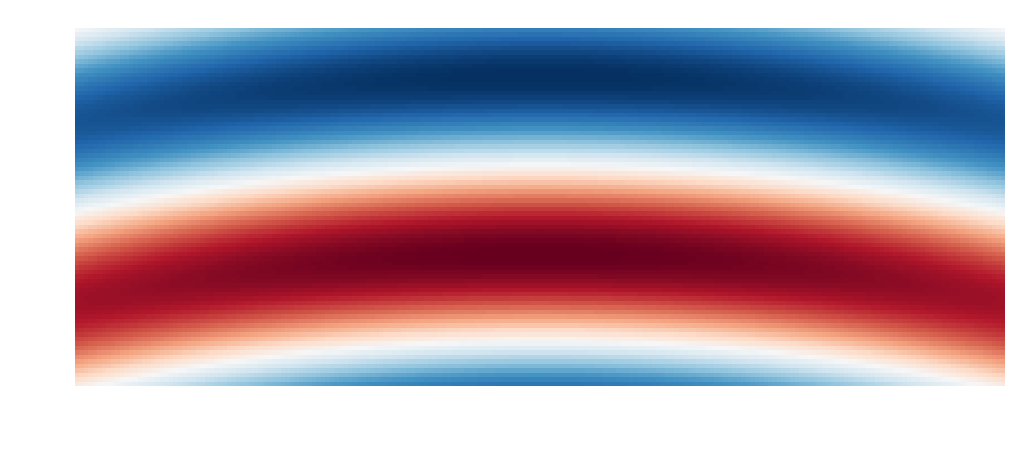

In [2]:
d2 = 20
h = 4

ff = sim.get_farfields(
    nearfield,
    resolution,
    center=mp.Vector3(y=0.5 * w + d2 + 0.5 * h),
    size=mp.Vector3(sx - 2 * dpml, h),
)

plt.figure(dpi=200)
plt.imshow(np.rot90(np.real(ff["Hz"]), 1), cmap="RdBu")
plt.axis("off")